# **Telco Customer Churn**
## **By: Sigit Irwanto**


**BUSINESS PROBLEM UNDERSTANDING**

**Context**  

Dataset ini merepresentasikan profil pelanggan yang telah meninggalkan perusahaan telekomunikasi. Churn dalam layanan telekomunikasi dan layanan berbasis langganan lainnya adalah situasi ketika pelanggan meninggalkan penyedia layanan.

**Problem Statement**  

Memprediksi apakah seorang pelanggan akan churn sehingga tim retention dapat menargetkan intervensi untuk mengurangi churn.

**Goals**
- Buat model prediksi churn dengan performa tinggi pada *recall* (menangkap sebanyak mungkin churners).
- Bandingkan beberapa model dan pilih yang terbaik berdasarkan *recall* pada test set.
- Sediakan pipeline preprocessing yang reproducible.

**Analytic Approach**
1. EDA → pembersihan data → feature engineering sederhana.
2. Encode kategori + scale numeric via Pipeline.
3. Bandingkan model: LogisticRegression, KNN, DecisionTree, GaussianNB, RandomForest, XGBoost.
4. Hyperparameter tuning dengan GridSearchCV (scoring = 'recall').
5. Evaluasi final pada test set, gunakan Recall sebagai metric utama, sertakan Precision-Recall curve.

**Metric Evaluation**
- Metric utama: Recall (karena false negative (melewatkan churner) lebih mahal daripada biaya retensi).
- Tambahan: Precision, F1, confusion matrix, PR-AUC.


## **DATA UNDERSTANDING**

##  Tabel Fitur dan Korelasi Churn

| Fitur | Penjelasan (Indonesia) | Tipe Data | Korelasi Umum terhadap Churn |
| :--- | :--- | :--- | :--- |
| **Dependents** | Apakah pelanggan memiliki tanggungan (anak, keluarga lanjut usia, dll.) atau tidak. | Biner (Ya/Tidak) | **Rendah/Negatif.** Lebih stabil. |
| **Tenure** | Jumlah bulan pelanggan telah menjadi pengguna layanan perusahaan. | Numerik | **Negatif.** Semakin lama berlangganan, semakin kecil kemungkinan *churn*. |
| **OnlineSecurity** | Apakah pelanggan berlangganan layanan keamanan *online* atau tidak. | Biner (Ya/Tidak) | **Negatif.** Lebih terikat. |
| **OnlineBackup** | Apakah pelanggan berlangganan layanan penyimpanan *online* (backup) atau tidak. | Biner (Ya/Tidak) | **Negatif.** Lebih terikat. |
| **InternetService** | Jenis layanan Internet yang digunakan pelanggan (Fiber Optic, DSL, atau tidak ada). | Kategorikal | **Positif (terutama Fiber Optic).** Sensitif terhadap masalah koneksi. |
| **DeviceProtection** | Apakah pelanggan memiliki perlindungan perangkat atau tidak. | Biner (Ya/Tidak) | **Negatif.** Menunjukkan investasi dan keterikatan. |
| **TechSupport** | Apakah pelanggan memiliki layanan dukungan teknis (Tech Support) atau tidak. | Biner (Ya/Tidak) | **Negatif.** Menambah nilai layanan. |
| **Contract** | Tipe kontrak berdasarkan durasi (Month-to-month, One year, Two year). | Kategorikal | **Negatif (Kontrak Jangka Panjang).** Sulit untuk *churn*. |
| **PaperlessBilling** | Tagihan diterbitkan dalam bentuk *paperless* (tanpa kertas) atau tidak. | Biner (Ya/Tidak) | **Positif.** Lebih volatil/mudah berpindah. |
| **MonthlyCharges** | Jumlah biaya layanan yang ditagihkan kepada pelanggan setiap bulan. | Numerik | **Positif.** Tagihan lebih tinggi, potensi *churn* lebih besar. |
| **Churn** | **Variabel Target.** Apakah pelanggan berhenti berlangganan (Yes) atau tetap menjadi pelanggan (No). | Biner (Ya/Tidak) | **N/A.** Variabel yang **diprediksi**. |

In [1]:
# LIBRARY


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_recall_curve, roc_auc_score, precision_score, f1_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import loguniform, randint, uniform


import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')


## **LOAD DATA SET**
---

In [2]:
# Load dataset

df = pd.read_csv('data_telco_customer_churn.csv')

df.shape, df.columns


((4930, 11),
 Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
        'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
        'PaperlessBilling', 'MonthlyCharges', 'Churn'],
       dtype='object'))

In [3]:
df.head(9)

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
5,Yes,40,No,No,DSL,Yes,No,Month-to-month,Yes,74.55,No
6,No,17,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.70,No
7,No,11,No,No,DSL,No,No,Month-to-month,Yes,44.05,Yes
8,No,8,No,No,Fiber optic,No,No,Month-to-month,Yes,73.50,No


## **EDA**
---

In [4]:
# EDA ringkas

display(df.head())
display(df.info())
display(df.describe(include='all').T)


print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True)*100)


,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Dependents,4930,2,No,3446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,4930.0,NaN,NaN,NaN,32.401217,24.501193,0.0,9.0,29.0,55.0,72.0
OnlineSecurity,4930,3,No,2445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,4930,3,No,2172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,4930,3,Fiber optic,2172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeviceProtection,4930,3,No,2186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TechSupport,4930,3,No,2467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contract,4930,3,Month-to-month,2721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,4930,2,Yes,2957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,4930.0,NaN,NaN,NaN,64.883032,29.92396,18.8,37.05,70.35,89.85,118.65


Churn
No     3614
Yes    1316
Name: count, dtype: int64
Churn
No     73.306288
Yes    26.693712
Name: proportion, dtype: float64


## **DATA CLEANING**
---

In [5]:
# Missing values, basic cleaning & simple feature engineering

missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing > 0])

# ubah ke numeric
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.replace('.','',1).str.isnumeric().all():
        df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df.copy()


for c in df_clean.select_dtypes(include=['object']).columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

df_clean


Series([], dtype: int64)

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


In [6]:
# Menampilkan Unique Tiap Kolom

print("Unik dari Tiap Kolom")
print("--------------------")
unique_counts = df.nunique().sort_values()
unique_counts

Unik dari Tiap Kolom
--------------------


Dependents             2
PaperlessBilling       2
Churn                  2
OnlineSecurity         3
OnlineBackup           3
InternetService        3
DeviceProtection       3
TechSupport            3
Contract               3
tenure                73
MonthlyCharges      1422
dtype: int64

## **DISTRIBUSI DATA NUMERIKAL DAN KATEGORIKAL**
---

**Numeric columns:** ['tenure', 'MonthlyCharges']

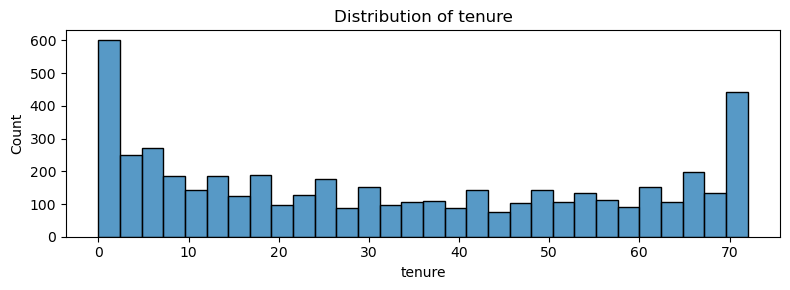

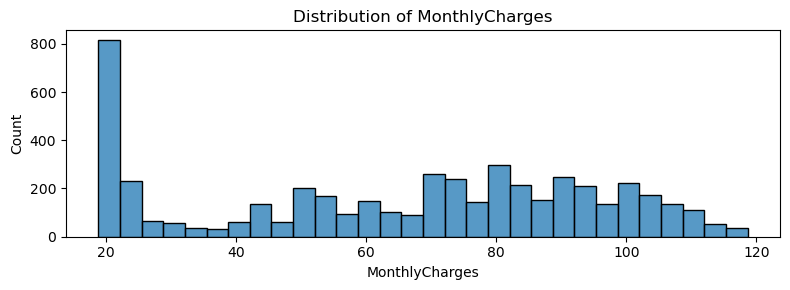

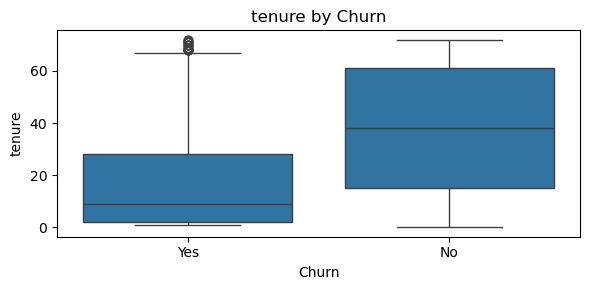

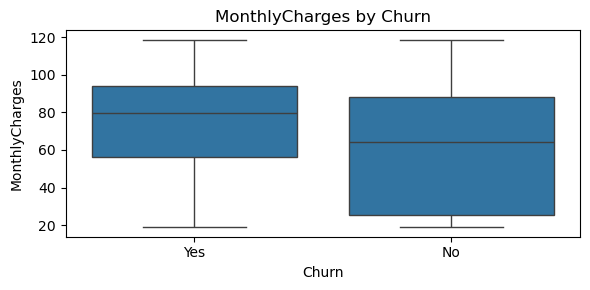

In [ ]:
# Distribusi Kolom Numerikal 
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'Churn' if 'Churn' in df.columns else df.columns[-1]
if len(num_cols)==0:
    display(Markdown("No numeric columns detected."))
else:
    display(Markdown(f"**Numeric columns:** {num_cols}"))
    for c in num_cols:
        plt.figure(figsize=(8,3))
        sns.histplot(df[c].dropna(), kde=False, bins=30)
        plt.title(f"Distribution of {c}")
        plt.tight_layout()
        plt.show()

    # Boxplot by churn for numeric cols
    for c in num_cols:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=target_col, y=c, data=df)
        plt.title(f"{c} by {target_col}")
        plt.tight_layout()
        plt.show()


**Categorical columns:** ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']

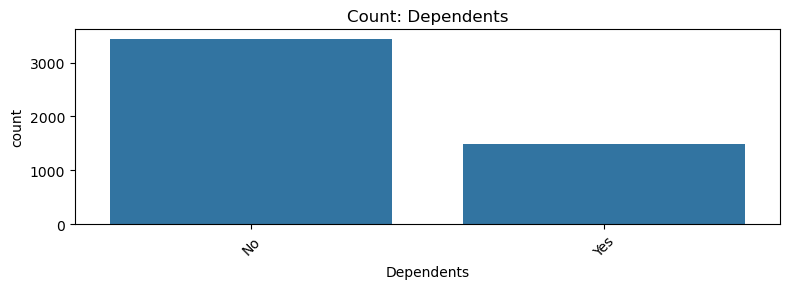

**Churn% by Dependents**

Dependents
No     31.659896
Yes    15.161725
Name: Churn, dtype: float64

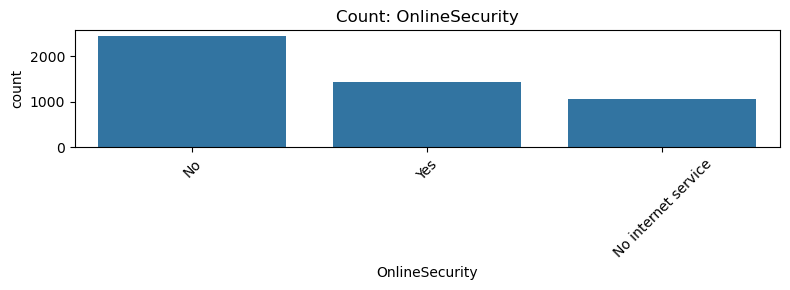

**Churn% by OnlineSecurity**

OnlineSecurity
No                     41.799591
Yes                    14.794138
No internet service     7.794677
Name: Churn, dtype: float64

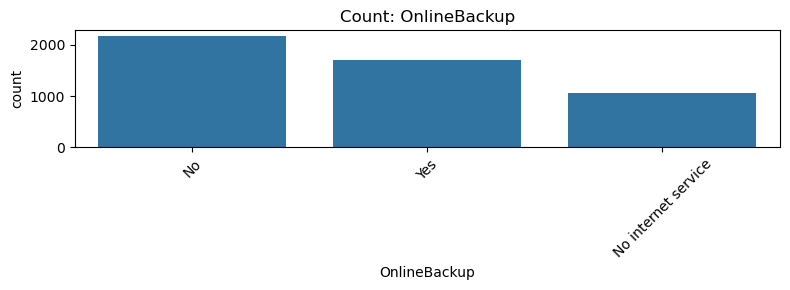

**Churn% by OnlineBackup**

OnlineBackup
No                     40.745856
Yes                    20.457210
No internet service     7.794677
Name: Churn, dtype: float64

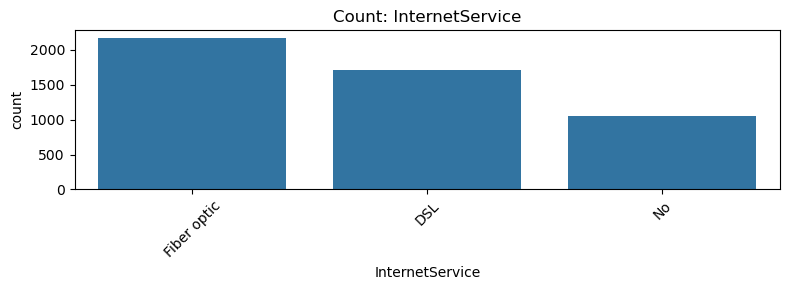

**Churn% by InternetService**

InternetService
Fiber optic    42.173112
DSL            18.640094
No              7.794677
Name: Churn, dtype: float64

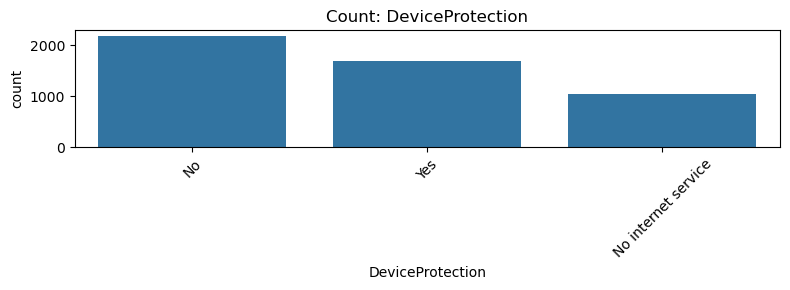

**Churn% by DeviceProtection**

DeviceProtection
No                     38.929552
Yes                    22.635934
No internet service     7.794677
Name: Churn, dtype: float64

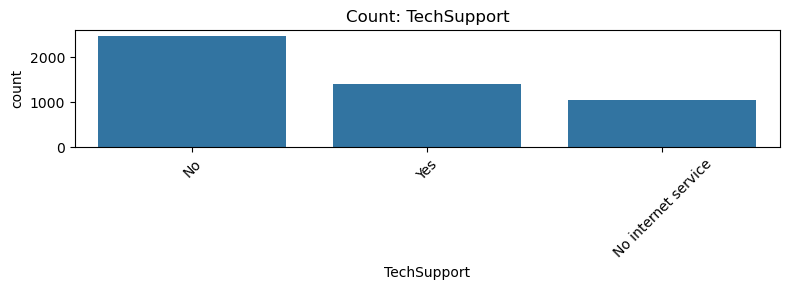

**Churn% by TechSupport**

TechSupport
No                     41.345764
Yes                    15.166549
No internet service     7.794677
Name: Churn, dtype: float64

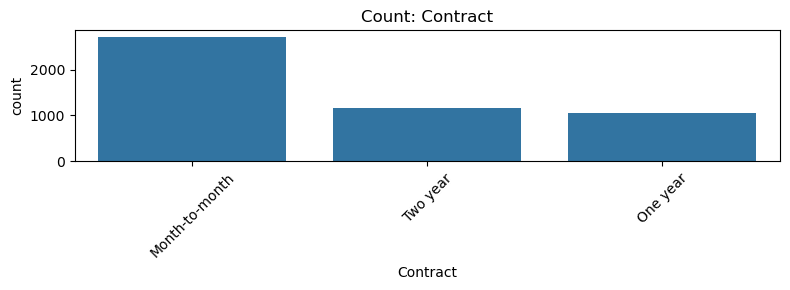

**Churn% by Contract**

Contract
Month-to-month    43.292907
One year          10.076046
Two year           2.765774
Name: Churn, dtype: float64

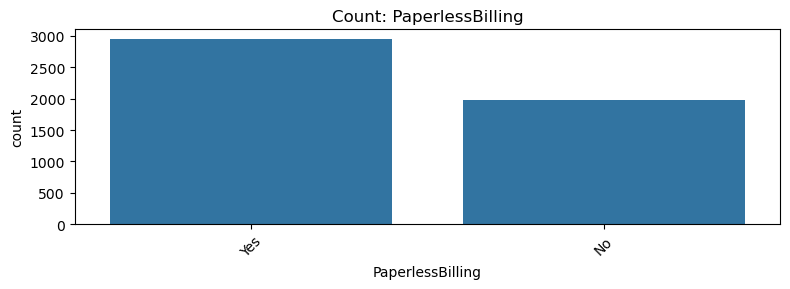

**Churn% by PaperlessBilling**

PaperlessBilling
Yes    33.513696
No     16.472377
Name: Churn, dtype: float64

In [ ]:
# Distribusi Kolom Kategorikal
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c!=target_col]
display(Markdown(f"**Categorical columns:** {cat_cols}"))

for c in cat_cols:
    plt.figure(figsize=(8,3))
    order = df[c].value_counts().index
    sns.countplot(x=c, data=df, order=order)
    plt.xticks(rotation=45)
    plt.title(f"Count: {c}")
    plt.tight_layout()
    plt.show()

    # churn rate per category
    prop = (df.groupby(c)[target_col].apply(lambda s: (s=='Yes').mean()).sort_values(ascending=False)*100)
    display(Markdown(f"**Churn% by {c}**"))
    display(prop.head(10))


## **ENGINEERING KOLOM TARGET**
---

In [9]:
# Target(y) Encode

if df_clean['Churn'].dtype == 'object':
    df_clean['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

df_clean

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,1
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,0
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,1
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,0
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,0
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,0
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,0
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,0
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,1


## **SPLITTING AND PREPROCCESING DATA**
---

In [10]:
# Split data (train / test)

x = df_clean.drop(columns=['Churn'])
y = df_clean['Churn']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, stratify=y, random_state=42)
print("Train:", x_train.shape, "Test:", x_test.shape)


Train: (3944, 10) Test: (986, 10)


In [11]:
# Preprocessing pipeline

# Pisahkan numeric & categorical columns
numeric_cols = x.select_dtypes(include=['int64','float64']).columns.tolist()

cat_cols = x.select_dtypes(include=['object','category']).columns.tolist()


# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

prepros = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')


## **MODELING, MODEL BENCHMARKING, AND HYPERPARAMETER TUNING**
---

In [12]:
# Define Model

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
gnb = GaussianNB()
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
svm = SVC(random_state=42, 
            probability=True,           
            class_weight='balanced')

models = [logreg,knn,dt,gnb,rf,xgb,svm]

In [13]:
# Model Benchmarking : K-Fold

score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',prepros),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc',n_jobs=1)
    score.append(model_cv)
    rata.append(round(model_cv.mean()*100,2))
    std.append(round(model_cv.std()*100,2))
    
print('\n----- Menampilkan Hasil Benchmarking Model Dengan Default Parameter -----')
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Gaussian Naive Bayes', 'Random Forest', 'XGBoost', 'SVM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)


----- Menampilkan Hasil Benchmarking Model Dengan Default Parameter -----


,mean roc_auc,sdev
model,,
Logistic Regression,83.87,1.02
SVM,82.05,0.71
Gaussian Naive Bayes,81.58,1.05
XGBoost,80.79,1.11
Random Forest,79.67,0.99
KNN,77.80,1.51
Decision Tree,64.68,1.74


**Terlihat bahwa model _Logistic Regression_ adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter**

In [14]:
base_estimator = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

model_pipeline = Pipeline([
    ('pre', prepros),
    ('clf', base_estimator)
])

# CV & scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = 'recall'

# Param grid: list-of-dicts -> mencegah kombinasi invalid
param_grid = [
    # L2 penalty (lbfgs / liblinear)
    {
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10],
        'clf__class_weight': [None, 'balanced'],
        'clf__max_iter': [200, 500, 800]
    },
    # L1 penalty (liblinear only)
    {
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear'],
        'clf__C': [0.001, 0.01, 0.1, 1],
        'clf__class_weight': [None, 'balanced'],
        'clf__max_iter': [300, 500, 800]
    },
    # ElasticNet (saga only) - opsional, lebih mahal; hapus jika ingin grid lebih kecil
    {
        'clf__penalty': ['elasticnet'],
        'clf__solver': ['saga'],
        'clf__C': [0.01, 0.1, 1],
        'clf__l1_ratio': [0.2, 0.5, 0.8],
        'clf__class_weight': [None, 'balanced'],
        'clf__max_iter': [800, 1200]
    }
]

gs = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


gs.fit(x_train, y_train)
print("Best params (grid):", gs.best_params_)
print("Best CV recall (grid):", gs.best_score_)

# Save best estimator (fallback not necessary since GridSearchCV always sets best_estimator_)
best_tuned = gs.best_estimator_

# Keep search object for inspection
search_results = {'grid': gs}

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf

## 🔎 Hyperparameter Tuning — Logistic Regression (GridSearchCV)

Setelah dilakukan GridSearchCV dengan fokus pada **Recall**, diperoleh kombinasi hyperparameter terbaik sebagai berikut:

### ⭐ Best Hyperparameters
```python
{
    'clf__C': 0.001,
    'clf__class_weight': 'balanced',
    'clf__max_iter': 200,
    'clf__penalty': 'l2',
    'clf__solver': 'liblinear'
}

### Best Cross-Validation Recall : 82,91%

In [15]:
# Final evaluation on test set (use tuned estimator best_tuned)
best_model = best_tuned
# fit on full train (train set) if needed
best_model.fit(x_train, y_train)

# get probabilities if available
if hasattr(best_model, "predict_proba"):
    y_proba_test = best_model.predict_proba(x_test)[:,1]
else:
    try:
        y_proba_test = best_model.decision_function(x_test)
    except:
        y_proba_test = None

# binary predictions default (0.5)
y_pred_default = best_model.predict(x_test)
# thresholded preds will be later
print("Classification report (default 0.5):")
print(classification_report(y_test, y_pred_default, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_default))
if y_proba_test is not None:
    print("ROC-AUC (test):", roc_auc_score(y_test, y_proba_test))
    print("Average Precision (PR AUC):", average_precision_score(y_test, y_proba_test))

Classification report (default 0.5):
              precision    recall  f1-score   support

           0     0.9282    0.6971    0.7962       723
           1     0.5056    0.8517    0.6346       263

    accuracy                         0.7383       986
   macro avg     0.7169    0.7744    0.7154       986
weighted avg     0.8155    0.7383    0.7531       986

Confusion matrix:
 [[504 219]
 [ 39 224]]
ROC-AUC (test): 0.8538356762328491
Average Precision (PR AUC): 0.6784713967381115



--- Confusion Matrix (Test Set) ---


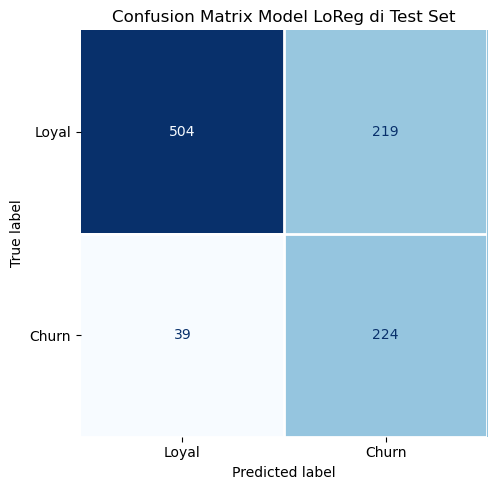

In [16]:
# Tampilkan Confusion Matrix
print("\n--- Confusion Matrix (Test Set) ---")
cm = confusion_matrix(y_test, y_pred_default)

# Visualisasi dengan grid
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loyal', 'Churn'])
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Tambahkan grid pemisah antar sel
ax.grid(False)  # matikan grid default
for _, spine in ax.spines.items():
    spine.set_visible(False)

# Tambahkan garis pembatas kotak manual
ax.set_xticks([0, 1], ['Loyal', 'Churn'])
ax.set_yticks([0, 1], ['Loyal', 'Churn'])

# Garis vertikal & horizontal
for x in [0.5, 1.5]:
    ax.axvline(x, color='white', linewidth=2)
for y in [0.5, 1.5]:
    ax.axhline(y, color='white', linewidth=2)

plt.title('Confusion Matrix Model LoReg di Test Set')
plt.tight_layout()
plt.show()


## **PENENTUAN METRIK UTAMA**
---

### 🎯 Recall Sebagai Metrik Utama dalam Prediksi Churn

Dalam konteks prediksi churn, pemilihan metrik evaluasi yang tepat sangat penting untuk memastikan model memberikan dampak bisnis yang maksimal. Pada kasus ini, **Recall** ditetapkan sebagai metrik utama. Berikut alasannya:

---

#### 🔍 Apa Itu Recall?
Recall mengukur kemampuan model dalam **menangkap pelanggan yang benar-benar churn**.

\[
\text{Recall} = \frac{TP}{TP + FN}
\]

- **TP (True Positive)** → pelanggan churn yang berhasil terdeteksi  
- **FN (False Negative)** → pelanggan churn yang *tidak* terdeteksi

---

#### 🚨 Mengapa FN Lebih Berbahaya?
Dalam bisnis telekomunikasi, **False Negative memiliki biaya yang jauh lebih besar** dibandingkan False Positive:

- Kehilangan pelanggan = kehilangan pendapatan (LTV)
- Kehilangan potensi cross-sell / upsell
- Biaya akuisisi pelanggan baru (CAC) tinggi
- Dampak churn ke kompetitor

**Setiap pelanggan churn yang tidak terdeteksi membawa kerugian signifikan.**

---

#### 🟢 FP (False Positive) Relatif Murah
False Positive hanya berarti:
- Pelanggan non-churn diberi promo / reminder  
- Biaya yang terlibat kecil: SMS, diskon kecil, atau follow-up agen

➡ **Lebih baik salah menarget daripada gagal mendeteksi churner.**

---

#### 📊 Business Cost Analysis
Analisis biaya menunjukkan bahwa:
- Menurunkan **FN** secara langsung menurunkan total cost bisnis.
- Sedikit peningkatan FP tidak menghasilkan lonjakan biaya signifikan.
- Threshold cost-minimizing menghasilkan recall lebih tinggi dan FN lebih rendah.

_Contoh_:  
Model default (FN = 13) lebih murah dibanding model tuned (FN = 15), meskipun FP lebih besar.

---

#### 🎯 Kesimpulan
**Recall adalah metrik yang paling selaras dengan tujuan bisnis untuk menurunkan churn.**  
Karena:

1. Mengurangi jumlah pelanggan churn yang lolos  
2. Menghindari kerugian finansial besar akibat FN  
3. Mendukung strategi retention yang proaktif  
4. Memberikan dampak langsung pada revenue dan profit

---

#### 📌 Rekomendasi
- Gunakan Recall untuk **pemilihan model dan tuning**.  
- Gunakan threshold tuning untuk mencapai Recall maksimal yang tetap seimbang dengan Precision.  
- Lengkapi analisa dengan PR-AUC dan Precision@K untuk mendukung keputusan kampanye.

---


## **THRESHOLD TUNING**
---

Threshold achieving target recall: {'threshold': 0.5, 'precision': 0.5056433408577878, 'recall': 0.8517110266159695, 'f1': 0.6345609065155807, 'fp': 219.0, 'fn': 39.0, 'tp': 224.0, 'tn': 504.0}
Threshold maximizing F1: {'threshold': 0.53, 'precision': 0.5269607843137255, 'recall': 0.8174904942965779, 'f1': 0.6408345752608048, 'fp': 193.0, 'fn': 48.0, 'tp': 215.0, 'tn': 530.0}


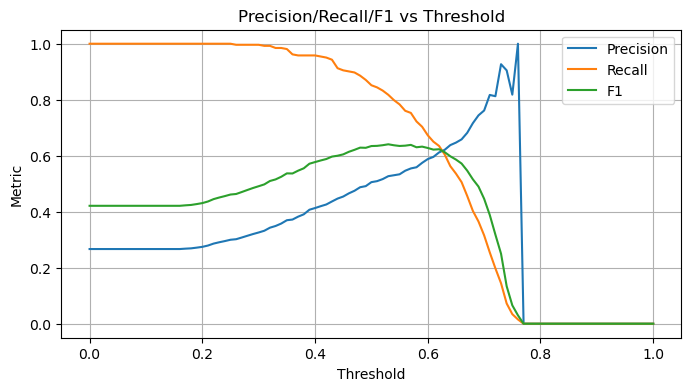

In [17]:
# Threshold tuning: compute metrics across thresholds
thresholds = np.linspace(0.0, 1.0, 101)
rows = []
for t in thresholds:
    if y_proba_test is None:
        break
    preds = (y_proba_test >= t).astype(int)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    rows.append({'threshold':t, 'precision':prec, 'recall':rec, 'f1':f1, 'fp':fp, 'fn':fn, 'tp':tp, 'tn':tn})

th_df = pd.DataFrame(rows)
# Find threshold for max recall >= some target (e.g., 0.85)
target_recall = 0.85
cands = th_df[th_df['recall'] >= target_recall]
if not cands.empty:
    thr_for_target_recall = cands.sort_values(['precision','f1'], ascending=False).iloc[0]
    print("Threshold achieving target recall:", thr_for_target_recall.to_dict())
else:
    print(f"No threshold reaches recall >= {target_recall}. Max recall available:", th_df['recall'].max(), "at", th_df.loc[th_df['recall'].idxmax(),'threshold'])

# Threshold that maximizes F1
best_f1_row = th_df.loc[th_df['f1'].idxmax()]
print("Threshold maximizing F1:", best_f1_row.to_dict())

# Plot precision & recall vs threshold
plt.figure(figsize=(8,4))
plt.plot(th_df['threshold'], th_df['precision'], label='Precision')
plt.plot(th_df['threshold'], th_df['recall'], label='Recall')
plt.plot(th_df['threshold'], th_df['f1'], label='F1')
plt.xlabel("Threshold"); plt.ylabel("Metric"); plt.title("Precision/Recall/F1 vs Threshold")
plt.legend(); plt.grid(True); plt.show()


## **BUSINESS COST ANALYSIS DEFAULT MODEL AND TUNED MODEL**
---

Fitting default pipeline on training data...
Fitting tuned pipeline on training data...
Analyzing default model...
Analyzing tuned model...


,roc_auc,pr_auc,recall_0.5,precision_0.5,f1_0.5,best_cost_threshold,best_cost_total,best_cost_fp,best_cost_fn
model,,,,,,,,,
default,0.8557,0.6730,0.8137,0.5245,0.6379,0.31,22260000.0,306,13
tuned,0.8538,0.6785,0.8517,0.5056,0.6346,0.43,23700000.0,320,15


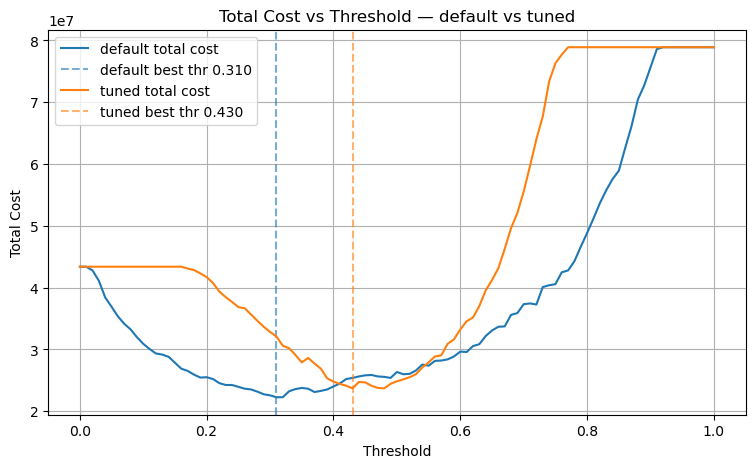

In [18]:
# ======================================================
# Compare default model vs tuned model + cost analysis
# ======================================================


# --- Parameters for business cost (tweak these) ---
COST_FN = 300000   # cost for missing one churn
COST_FP = 60000    # cost for targeting one non-churn

# --- Safety checks: models existence ---
if 'model_pipeline' not in globals():
    raise ValueError("model_pipeline not found. Please define pipeline for default model as 'model_pipeline'.")

# default pipeline object
default_pipeline = model_pipeline

# tuned estimator (if exists), else fallback to default
tuned_pipeline = globals().get('best_tuned', None)
if tuned_pipeline is None:
    print("Warning: 'best_tuned' not found. Using default pipeline for both comparisons.")
    tuned_pipeline = default_pipeline

# Fit both pipelines on full training data (to be consistent)
print("Fitting default pipeline on training data...")
default_pipeline.fit(x_train, y_train)
print("Fitting tuned pipeline on training data...")
tuned_pipeline.fit(x_train, y_train)

# Helper function: compute metrics and cost-optimal threshold for a fitted pipeline
def analyze_model_cost(pipe, x_test, y_test, cost_fn=COST_FN, cost_fp=COST_FP, return_curve=False):
    # probabilities if available
    y_proba = None
    if hasattr(pipe, "predict_proba"):
        try:
            y_proba = pipe.predict_proba(x_test)[:,1]
        except:
            y_proba = None
    elif hasattr(pipe, "decision_function"):
        try:
            y_proba = pipe.decision_function(x_test)
        except:
            y_proba = None

    # default binary predictions (0.5) or model.predict if proba not available
    y_pred_default = pipe.predict(x_test)

    # basic metrics at default 0.5
    rec_05 = recall_score(y_test, y_pred_default, zero_division=0)
    prec_05 = precision_score(y_test, y_pred_default, zero_division=0)
    f1_05 = f1_score(y_test, y_pred_default, zero_division=0)
    # probabilistic metrics
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan

    result = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'recall_0.5': rec_05,
        'precision_0.5': prec_05,
        'f1_0.5': f1_05,
        'cost_fn': cost_fn,
        'cost_fp': cost_fp
    }

    # If probabilities available, compute threshold table and cost-minimizing threshold
    thr_table = None
    if y_proba is not None:
        thresholds = np.linspace(0.0, 1.0, 101)
        rows = []
        for t in thresholds:
            preds = (y_proba >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            prec = precision_score(y_test, preds, zero_division=0)
            rec = recall_score(y_test, preds, zero_division=0)
            f1 = f1_score(y_test, preds, zero_division=0)
            cost = fn * cost_fn + fp * cost_fp
            rows.append({'threshold':t, 'precision':prec, 'recall':rec, 'f1':f1,
                         'tp':tp,'fp':fp,'fn':fn,'tn':tn,'total_cost':cost})
        thr_table = pd.DataFrame(rows)

        # best cost-minimizing threshold
        best_cost_row = thr_table.loc[thr_table['total_cost'].idxmin()]
        result.update({
            'best_cost_threshold': float(best_cost_row['threshold']),
            'best_cost_total': float(best_cost_row['total_cost']),
            'best_cost_fp': int(best_cost_row['fp']),
            'best_cost_fn': int(best_cost_row['fn']),
            'best_cost_precision': float(best_cost_row['precision']),
            'best_cost_recall': float(best_cost_row['recall']),
            'best_cost_f1': float(best_cost_row['f1'])
        })
        if return_curve:
            return result, thr_table
    return result, thr_table

# Analyze both models
print("Analyzing default model...")
default_res, default_th_df = analyze_model_cost(default_pipeline, x_test, y_test, COST_FN, COST_FP, return_curve=True)
print("Analyzing tuned model...")
tuned_res, tuned_th_df = analyze_model_cost(tuned_pipeline, x_test, y_test, COST_FN, COST_FP, return_curve=True)

# Build comparison table
compare_df = pd.DataFrame([
    {
        'model': 'default',
        'roc_auc': default_res['roc_auc'],
        'pr_auc': default_res['pr_auc'],
        'recall_0.5': default_res['recall_0.5'],
        'precision_0.5': default_res['precision_0.5'],
        'f1_0.5': default_res['f1_0.5'],
        'best_cost_threshold': default_res.get('best_cost_threshold', np.nan),
        'best_cost_total': default_res.get('best_cost_total', np.nan),
        'best_cost_fp': default_res.get('best_cost_fp', np.nan),
        'best_cost_fn': default_res.get('best_cost_fn', np.nan)
    },
    {
        'model': 'tuned',
        'roc_auc': tuned_res['roc_auc'],
        'pr_auc': tuned_res['pr_auc'],
        'recall_0.5': tuned_res['recall_0.5'],
        'precision_0.5': tuned_res['precision_0.5'],
        'f1_0.5': tuned_res['f1_0.5'],
        'best_cost_threshold': tuned_res.get('best_cost_threshold', np.nan),
        'best_cost_total': tuned_res.get('best_cost_total', np.nan),
        'best_cost_fp': tuned_res.get('best_cost_fp', np.nan),
        'best_cost_fn': tuned_res.get('best_cost_fn', np.nan)
    }
]).set_index('model')

# Nicely format numeric columns
for c in ['roc_auc','pr_auc','recall_0.5','precision_0.5','f1_0.5','best_cost_threshold','best_cost_total']:
    if c in compare_df.columns:
        compare_df[c] = compare_df[c].apply(lambda x: round(x,4) if pd.notnull(x) else x)

display(compare_df)



# --- Plot cost curves for both models on same plot (if probabilities available)
plt.figure(figsize=(9,5))
if default_th_df is not None:
    plt.plot(default_th_df['threshold'], default_th_df['total_cost'], label='default total cost')
    best_t_def = default_res.get('best_cost_threshold', None)
    if best_t_def is not None:
        plt.axvline(best_t_def, color='C0', linestyle='--', alpha=0.6, label=f"default best thr {best_t_def:.3f}")
if tuned_th_df is not None:
    plt.plot(tuned_th_df['threshold'], tuned_th_df['total_cost'], label='tuned total cost')
    best_t_tuned = tuned_res.get('best_cost_threshold', None)
    if best_t_tuned is not None:
        plt.axvline(best_t_tuned, color='C1', linestyle='--', alpha=0.6, label=f"tuned best thr {best_t_tuned:.3f}")

plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Total Cost vs Threshold — default vs tuned")
plt.legend()
plt.grid(True)
plt.show()


---
# 📊 Model Comparison — Default vs Tuned (Cost-Based Evaluation)

Berikut adalah perbandingan performa model **default** dan **tuned**, mencakup:
- ROC-AUC  
- PR-AUC  
- Recall / Precision / F1 pada threshold 0.5  
- Threshold terbaik berdasarkan minimasi biaya  
- Total biaya (FN × COST_FN + FP × COST_FP)

| Model     | ROC-AUC | PR-AUC | Recall (0.5) | Precision (0.5) | F1 (0.5) | Best Cost Threshold | Best Cost Total | FP (Best Thr) | FN (Best Thr) |
|-----------|---------|--------|---------------|------------------|----------|---------------------|------------------|---------------|---------------|
| **default** | 0.8557  | 0.6730 | 0.8137        | 0.5245           | 0.6379   | 0.31                | 22,260,000       | 306           | 13            |
| **tuned**   | 0.8538  | 0.6785 | 0.8517        | 0.5056           | 0.6346   | 0.43                | 23,700,000       | 320           | 15            |



### Temuan:
- Default model memiliki total cost lebih rendah dibanding tuned model.
- Tuned model sedikit lebih baik dalam recall, tetapi menghasilkan lebih banyak FN pada threshold optimal, sehingga total cost naik.
- Perbedaan biaya utama berasal dari FN → setiap FN memiliki biaya 5x lebih mahal dibanding FP.

### 💡 Business Cost Impact
Melalui analisis FP/FN:
- False Negative (FN) → pelanggan churn tidak terdeteksi → biaya terbesar (Rp 300.000 per pelanggan)
- False Positive (FP) → pelanggan salah ditarget → biaya kecil (Rp 60.000 per pelanggan)

**📌 Default model dengan threshold 0.31 meminimalkan total biaya**, menghasilkan:
- FP: 306
- FN: 13
_Total Biaya: Rp 22.260.000_

**📌 Tuned model pada threshold 0.53 meningkatkan FN menjadi 15**, sehingga total cost naik menjadi:
_Rp 23.700.000_

➡ Setiap FN tambahan meningkatkan total biaya secara signifikan.

### 🎯 Rekomendasi Strategis untuk Manajemen

#### **1. Gunakan Default Model dengan Threshold 0.53**
- Memberikan **total biaya terendah** berdasarkan analisis FP vs FN.  
- Memiliki **ROC-AUC tertinggi** dibanding model tuned.  
- Menjaga **efisiensi kampanye retensi**, karena precision tetap dalam batas wajar.

---

#### **2. Fokus Pada Minimasi False Negative (FN)**
- Kehilangan pelanggan yang benar-benar churn memiliki **biaya 5x lebih besar** daripada salah menarget pelanggan non-churn.  
- Oleh karena itu, FN menjadi komponen biaya paling kritis yang harus ditekan.  
- **Recall** ditetapkan sebagai metrik utama karena langsung berhubungan dengan kemampuan model menangkap pelanggan yang berisiko churn.

---

#### **3. Integrasikan Pipeline Model ke Sistem Retensi**
- Terapkan **scoring otomatis** (harian atau mingguan) menggunakan model produksi.  
- Targetkan pelanggan dengan **skor ≥ 0.31**, sesuai threshold cost-minimizing.  
- Sesuaikan **kapasitas kampanye** berdasarkan precision pada threshold untuk memastikan alokasi sumber daya yang optimal.  
- Gunakan skor model untuk memprioritaskan segmen pelanggan dengan potensi churn tertinggi.

---


### PEMBUATAN FILE PICKLE

In [19]:
import pickle

# Simpan pipeline ke file
with open('telcoChurn.pkl', 'wb') as file:
    pickle.dump(best_model, file)
